In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd
import seaborn as sns 
import codecs, json
import math

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# Data Prep

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]
x_3 = np.linspace(-1,1,256)

X, Y, Z = np.meshgrid(x_1,x_2,x_3) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.


In [3]:
X_v_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None],Z.flatten(order='F')[:,None]))

lb = np.array([-1, -1, -1]) #lower bound
ub = np.array([1, 1, 1])  #upper bound

usol = 1/(4 * np.pi)*np.log((np.sqrt(X**2 + Y**2 + (Z-1)**2)-(Z-1))/(np.sqrt(X**2 + Y**2 + (Z+1)**2)-(Z+1)))+1/(4*np.pi)*1/(np.sqrt(X**2+(Y+1/2)**2+Z**2))+1/(4*np.pi)*1/(np.sqrt(X**2+(Y-1/2)**2+Z**2))+math.e**(X*Y*Z)
vsol = math.e**(X*Y*Z)

v = vsol.flatten('F')[:,None] 

# Training Data

In [4]:
def trainingdata(N_v,N_f):
    
    leftedge_x = np.hstack((X[0,:].flatten('a')[:,None], Y[0,:].flatten('a')[:,None], Z[0,:].flatten('a')[:,None]))
    leftedge_v = vsol[0,:].flatten('a')[:,None]
    
    rightedge_x = np.hstack((X[-1,:].flatten('a')[:,None], Y[-1,:].flatten('a')[:,None], Z[-1,:].flatten('a')[:,None]))
    rightedge_v = vsol[-1,:].flatten('a')[:,None]
    
    backedge_x = np.hstack((X[:,0].flatten('a')[:,None], Y[:,0].flatten('a')[:,None], Z[:,0].flatten('a')[:,None]))
    backedge_v = vsol[:,0].flatten('a')[:,None]
    
    frontedge_x = np.hstack((X[:,-1].flatten('a')[:,None], Y[:,-1].flatten('a')[:,None], Z[:,-1].flatten('a')[:,None]))
    frontedge_v = vsol[:,-1].flatten('a')[:,None]
    
    bottomedge_x = np.hstack((X[:,:,0].flatten('a')[:,None], Y[:,:,0].flatten('a')[:,None], Z[:,:,0].flatten('a')[:,None]))
    bottomedge_v = vsol[:,:,0].flatten('a')[:,None]
    
    topedge_x = np.hstack((X[:,:,-1].flatten('a')[:,None], Y[:,:,-1].flatten('a')[:,None], Z[:,:,-1].flatten('a')[:,None]))
    topedge_v = vsol[:,:,-1].flatten('a')[:,None]
    
    all_X_v_train = np.vstack([leftedge_x, rightedge_x, backedge_x, frontedge_x, bottomedge_x, topedge_x])
    all_v_train = np.vstack([leftedge_v, rightedge_v, backedge_v, frontedge_v, bottomedge_v, topedge_v])  
     
    #choose random N_v points for training
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False) 
    
    X_v_train = all_X_v_train[idx[0:N_v], :] #choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v],:]      #choose corresponding v
    
    #Collocation Points

    X_f = lb + (ub-lb)*lhs(3,N_f)
    X_f_train = np.vstack((X_f, X_v_train)) # append training points to collocation points 
    
    return X_f_train, X_v_train, v_train

# PINN

Creating sequential layers using the class tf.Module


In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):

        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            
            #w = tf.cast(tf.ones([input_dim, output_dim]), dtype = 'float64')

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim
            
        self.X = np.zeros(self.parameters) #store iterates
        self.G = np.zeros(self.parameters) #store gradients
        self.store = np.zeros((max_iter,3)) #store computed values for plotting
        self.iter_counter = 0 # iteration counter for optimizer
    
    def evaluate(self,x):
        
        #preprocessing input 
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        g = tf.Variable(x, dtype = 'float64', trainable = False)
        
        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]
        x_3_f = g[:,2:3]
        
        s = y-self.evaluate(x)
        loss_v = tf.reduce_mean(tf.square(s))
        
        return loss_v

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        
        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]
        x_3_f = g[:,2:3]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)
            tape.watch(x_3_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0], x_3_f[:,0]], axis=1)

            v = self.evaluate(g)
            v_x_1 = tape.gradient(v,x_1_f)
            v_x_2 = tape.gradient(v,x_2_f)
            v_x_3 = tape.gradient(v,x_3_f)

        #v_xx_1 = tape.gradient(v_x_1,x_1_f)
        #v_xx_2 = tape.gradient(v_x_2,x_2_f)

        del tape
        
        k = math.e**x_3_f
        F = -(x_2_f**2*x_3_f**2+x_1_f**2*x_3_f**2+x_1_f**2*x_2_f**2+x_1_f*x_2_f)*math.e**(x_1_f*x_2_f*x_3_f+x_3_f)
        
        f = 1/2 * k * (v_x_1**2 + v_x_2**2 + v_x_3**2) - F * v

        loss_f = tf.reduce_mean(f)

        return loss_f, f
    
    def loss(self,x,y,g,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f, f = self.loss_PDE(g)

        loss = sigma/2 * loss_v + loss_f

        return loss, loss_v, loss_f 
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            
            tape.watch(self.trainable_variables)
            loss_val, loss_v, loss_f = self.loss(X_v_train, v_train, X_f_train, sigma)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
        
        del tape
        
        grads_1d = [ ] #store 1d grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        
        return loss_val.numpy(), grads_1d.numpy()

# Loss Function

The loss function consists of two parts:

loss_BC: MSE error of boundary losses
loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:26: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  results = scipy.optimize.minimize(fun = PINN.optimizerfunc,
C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:55: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  results = scipy.optimize.minimize(fun = PINN.optimizerfunc,
C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:55: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  results = scipy.optimize.minimize(fun = PINN.optimizerfunc,


Training time: 1982.06
penalty factor: 2594.93
error_L^2: 0.0033


C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, usol[:,:,0], cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:98: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_1, x_2, u_pred[:,:,0], cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_25284/3794828287.py:107: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensio

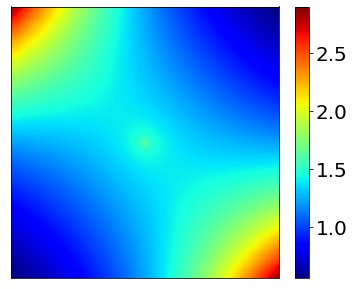

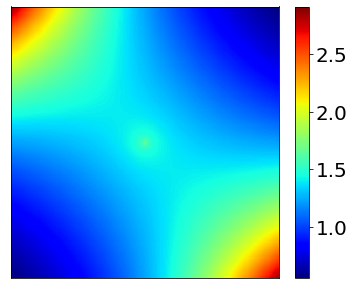

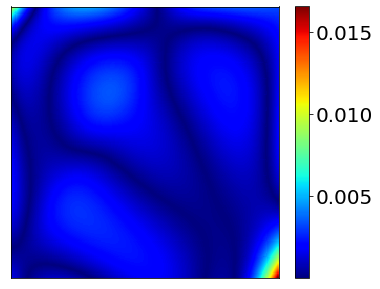

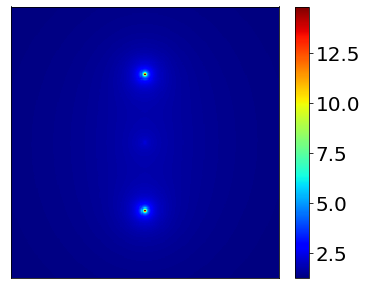

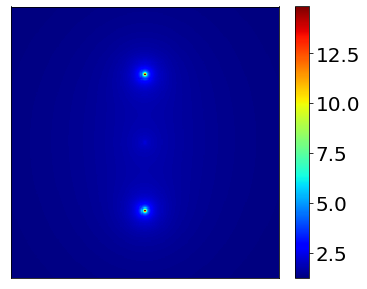

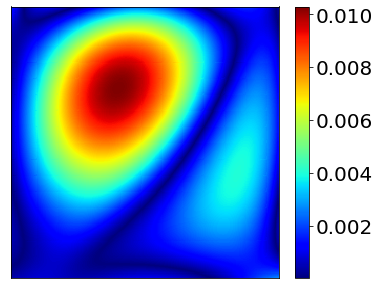

In [6]:
N_v = 400 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_v_train, v_train = trainingdata(N_v,N_f)

sigma_vec = []
error_vec = []

layers = np.array([3,6,6,1]) #3 hidden layers

maxcor = 200 
max_iter = 2000

start_time = time.time()

rou = 1.5
sigma = 20
sigma_vec.append(sigma)

PINN = Sequentialmodel(layers,sigma) 

init_params = PINN.get_weights().numpy()

# train the model with Scipy BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc,
                                  x0 = init_params,
                                  args=(),
                                  method='BFGS',
                                  jac= True,     # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = None, 
                                  options = {'disp': None,
                                            'maxcor': maxcor, 
                                            'ftol': 5e-10, # 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 2500,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})


PINN.set_weights(results.x)
v_pred = PINN.evaluate(X_v_test)
error = np.linalg.norm((v-v_pred),2)/np.linalg.norm(v,2)
error_vec.append(error)

while error>1e-3 and sigma<2000:
    sigma = rou * sigma
    sigma_vec.append(sigma)
    PINN = Sequentialmodel(layers,sigma) 

    init_params = PINN.get_weights().numpy()

    # train the model with Scipy BFGS optimizer
    results = scipy.optimize.minimize(fun = PINN.optimizerfunc,
                                      x0 = init_params,
                                      args=(),
                                      method='BFGS',
                                      jac= True,     # If jac is True, fun is assumed to return the gradient along with the objective function
                                      callback = None, 
                                      options = {'disp': None,
                                                'maxcor': maxcor, 
                                                'ftol': 5e-10, # 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                                'gtol': 5e-10, 
                                                'maxfun':  50000, 
                                                'maxiter': 2500,
                                                'iprint': -1,   #print update every 50 iterations
                                                'maxls': 50})
    PINN.set_weights(results.x)
    v_pred = PINN.evaluate(X_v_test)
    error = np.linalg.norm((v-v_pred),2)/np.linalg.norm(v,2)
    error_vec.append(error)
    
elapsed = time.time() - start_time              
print('Training time: %.2f' % (elapsed))

print('penalty factor: %.2f' % (sigma))
print('error_L^2: %.4f' % (error))

x_1_f = X_v_test[:,0:1]
x_2_f = X_v_test[:,1:2]
x_3_f = X_v_test[:,2:3]
u_pred = 1/(4 * np.pi)*np.log((np.sqrt(x_1_f**2 + x_2_f**2 + (x_3_f-1)**2)-(x_3_f-1))/(np.sqrt(x_1_f**2 + x_2_f**2 + (x_3_f+1)**2)-(x_3_f+1)))+1/(4*np.pi)*1/(np.sqrt(x_1_f**2+(x_2_f+1/2)**2+x_3_f**2))+1/(4*np.pi)*1/(np.sqrt(x_1_f**2+(x_2_f-1/2)**2+x_3_f**2))+ v_pred

u_pred = np.reshape(u_pred,(256,256,256),order='F')

# Plotting
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(x_1, x_2, usol[:,:,0], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true1',bbox_inches='tight')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred[:,:,0], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred1',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol[:,:,0] - u_pred[:,:,0]), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error1',bbox_inches='tight')

# Plotting
#Ground truth
fig_4 = plt.figure(4, figsize=(6, 5))
plt.pcolor(x_1, x_2, usol[:,:,128], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true2',bbox_inches='tight')

# Prediction
fig_5 = plt.figure(5, figsize=(6, 5))
plt.pcolor(x_1, x_2, u_pred[:,:,128], cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred2',bbox_inches='tight')

# Error
fig_6 = plt.figure(6, figsize=(6, 5))
plt.pcolor(x_1, x_2, np.abs(usol[:,:,128] - u_pred[:,:,128]), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error2',bbox_inches='tight')